In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [2]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Select GPU 0
    print(f"Using device: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("CUDA not available, using CPU")

Using device: Tesla P100-PCIE-16GB


# Exploratory Data Analysis

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv")

test_df = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv")

## Cleaning the Training Set

In [4]:
train_df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [5]:
train_df.columns = ['id', 'game', 'sentiment', 'content']

# Drop unnecessary column (filled with None values)
train_df = train_df[['id', 'game', 'sentiment', 'content']]

In [6]:
train_df = train_df.drop(columns=['id', 'game'])

train_df.head()

,sentiment,content
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [7]:
print(len(train_df))

74681


In [8]:
nan_values = train_df.isna().sum()
duplicate_values = train_df.duplicated().sum()

nan_values

sentiment      0
content      686
dtype: int64

In [9]:
# Remove NaN values
train_df = train_df.dropna()

In [10]:
duplicate_values

4909

In [11]:
# Remove duplicate rows
train_df = train_df.drop_duplicates()

In [12]:
# Print unique sentiment names
unique_sentiments = train_df['sentiment'].unique()
unique_sentiments

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [15]:
# Replace 'Irrelevant' with 'Neutral'
train_df['sentiment'] = train_df['sentiment'].replace('Irrelevant', 'Neutral')

# Calculate sentiment distribution
sentiment_distribution = train_df['sentiment'].value_counts()

# Print sentiment distribution
sentiment_distribution

sentiment
Neutral     29394
Negative    21237
Positive    19137
Name: count, dtype: int64

In [16]:
# Check for NaN values after cleaning
nan_check = train_df.isna().sum()
print("NaN values after cleaning:")
print(nan_check)

# Check for duplicate rows after cleaning
duplicate_check = train_df.duplicated().sum()
print("\nDuplicate rows after cleaning:")
print(duplicate_check)

# Verify the sentiment distribution
print("\nSentiment distribution after cleaning:")
print(train_df['sentiment'].value_counts())

NaN values after cleaning:
sentiment    0
content      0
dtype: int64

Duplicate rows after cleaning:
74

Sentiment distribution after cleaning:
sentiment
Neutral     29394
Negative    21237
Positive    19137
Name: count, dtype: int64


In [17]:
# Remove duplicate rows
train_df = train_df.drop_duplicates()

In [18]:
duplicate_check = train_df.duplicated().sum()
print("\nDuplicate rows after cleaning:")
print(duplicate_check)


Duplicate rows after cleaning:
0


In [19]:
train_df.head(10)

,sentiment,content
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
5,Positive,So I spent a few hours making something for fu...
6,Positive,So I spent a couple of hours doing something f...
7,Positive,So I spent a few hours doing something for fun...
8,Positive,So I spent a few hours making something for fu...
9,Positive,2010 So I spent a few hours making something f...


## Cleaning the Test Set

In [20]:
test_df.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [21]:
test_df.columns = ['id', 'game', 'sentiment', 'content']

# Drop unnecessary column (filled with None values)
test_df = test_df[['id', 'game', 'sentiment', 'content']]

In [22]:
test_df = test_df.drop(columns=['id', 'game'])

test_df.head()

,sentiment,content
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [23]:
nan_values = test_df.isna().sum()
duplicate_values = test_df.duplicated().sum()

nan_values, duplicate_values

(sentiment    0
 content      0
 dtype: int64,
 1)

In [24]:
# Remove NaN values
test_df = test_df.dropna()

In [25]:
# Remove duplicate rows
test_df = test_df.drop_duplicates()

In [26]:
# Print unique sentiment names
unique_sentiments = test_df['sentiment'].unique()
unique_sentiments

array(['Neutral', 'Negative', 'Positive', 'Irrelevant'], dtype=object)

In [27]:
# Replace 'Irrelevant' with 'Neutral'
test_df['sentiment'] = test_df['sentiment'].replace('Irrelevant', 'Neutral')

# Calculate sentiment distribution
sentiment_distribution = test_df['sentiment'].value_counts()

# Print sentiment distribution
sentiment_distribution

sentiment
Neutral     456
Positive    276
Negative    266
Name: count, dtype: int64

In [28]:
# Check for NaN values after cleaning
nan_check = test_df.isna().sum()
print("NaN values after cleaning:")
print(nan_check)

# Check for duplicate rows after cleaning
duplicate_check = test_df.duplicated().sum()
print("\nDuplicate rows after cleaning:")
print(duplicate_check)

# Verify the sentiment distribution
print("\nSentiment distribution after cleaning:")
print(test_df['sentiment'].value_counts())

NaN values after cleaning:
sentiment    0
content      0
dtype: int64

Duplicate rows after cleaning:
0

Sentiment distribution after cleaning:
sentiment
Neutral     456
Positive    276
Negative    266
Name: count, dtype: int64


In [29]:
test_df.head(10)

,sentiment,content
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
5,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...
6,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ..."
7,Positive,my ass still knee-deep in Assassins Creed Odys...
8,Negative,FIX IT JESUS ! Please FIX IT ! What In the wor...
9,Positive,The professional dota 2 scene is fucking explo...


# Data Preprocessing

In [30]:
len(train_df), len(test_df)

(69694, 998)

In [32]:
# Train / Val Set
from sklearn.model_selection import train_test_split

X = train_df['content']
y = train_df['sentiment']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y  
)

print(f"Training Set: {len(X_train)} examples")
print(f"Validation Set: {len(X_val)} examples")

Training Set: 62724 examples
Validation Set: 6970 examples


In [37]:
# Test Set
X_test = test_df['content']  
y_test = test_df['sentiment']  

In [40]:
print(f"Test Set: {len(X_test)} examples")

Test Set: 998 examples


In [34]:
reference_reviews = ["@GameDevStudio The new patch completely ruined the gameplay. Frame drops everywhere - unplayable!",
                    "Not sure if I should spend my money on this game, looks fun but a bit skeptical. Any thoughts?",
                    "Big thanks to @ConsoleBrand for their amazing customer support! My console is back to working perfectly.",
                    "Had to cancel my order because the delivery was delayed for the third time. Frustrating.",
                    "Absolutely loved the new RPG! Stunning graphics, deep story, and engaging gameplay."]

# Testing for the Un-finetuned Model

In [35]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd

# Initialize tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
model.to(device)

max_length = 64  
# Tokenization function
def tokenize_data(texts, tokenizer, max_length=64):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
# Tokenize validation set
X_val_tokenized = tokenize_data(X_val, tokenizer, max_length=max_length)

# Tokenize test set
X_test_tokenized = tokenize_data(X_test, tokenizer, max_length=max_length)

In [41]:
# Label mapping for sentiments
label_mapping = {'Positive': 0, 'Negative': 1, 'Neutral': 2}

# Encode validation labels
y_val_encoded = y_val.map(label_mapping).to_numpy()
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)

# Encode test labels
y_test_encoded = y_test.map(label_mapping).to_numpy()
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

In [42]:
# Print validation labels info
print(f"Validation Labels Shape: {y_val_tensor.shape}")
print(f"Validation Labels (First 5): {y_val_tensor[:5]}")

# Print test labels info
print(f"Test Labels Shape: {y_test_tensor.shape}")
print(f"Test Labels (First 5): {y_test_tensor[:5]}")

Validation Labels Shape: torch.Size([6970])
Validation Labels (First 5): tensor([2, 1, 0, 1, 0])
Test Labels Shape: torch.Size([998])
Test Labels (First 5): tensor([2, 1, 1, 2, 1])


In [43]:
# Validation dataset and dataloader
batch_size = 8
val_dataset = TensorDataset(
    X_val_tokenized['input_ids'], 
    X_val_tokenized['attention_mask'], 
    y_val_tensor
)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Test dataset and dataloader
test_dataset = TensorDataset(
    X_test_tokenized['input_ids'], 
    X_test_tokenized['attention_mask'], 
    y_test_tensor
)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [44]:
# Verify DataLoader
for batch in val_loader:
    input_ids, attention_mask, labels = batch
    print("Validation Input IDs:", input_ids.shape)
    print("Validation Attention Mask:", attention_mask.shape)
    print("Validation Labels:", labels.shape)
    break

Validation Input IDs: torch.Size([8, 64])
Validation Attention Mask: torch.Size([8, 64])
Validation Labels: torch.Size([8])


In [45]:
print("First input IDs:", input_ids[0])
print("First attention mask:", attention_mask[0])
print("First label:", labels[0])

First input IDs: tensor([  101, 10657,  2293, 14638, 17561,  1012,  1012,  1012,  1996,  2204,
         2739,  2003,  2008,  2087,  1997,  2122,  2097,  2272,  2067,  2130,
         2044,  2256,  2334,  3652,  4224,  1999,  5169,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
First attention mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
First label: tensor(2)


In [46]:
# Evaluation function for validation and test sets
def evaluate_model(loader, target_names):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            predictions = torch.argmax(logits, dim=-1).cpu().numpy()
            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu().numpy())
    
    # Generate classification report
    report = classification_report(
        all_labels, 
        all_predictions, 
        target_names=target_names, 
        output_dict=True, 
        zero_division=0
    )
    return pd.DataFrame(report).transpose()

In [47]:
# Evaluate on validation set
val_report = evaluate_model(val_loader, target_names=['Positive', 'Negative', 'Neutral'])
print("Validation Performance:")
print(val_report.round(2))

# Evaluate on test set
test_report = evaluate_model(test_loader, target_names=['Positive', 'Negative', 'Neutral'])
print("Test Performance:")
print(test_report.round(2))

Validation Performance:
              precision  recall  f1-score  support
Positive           0.28    0.99      0.43  1914.00
Negative           0.17    0.00      0.00  2124.00
Neutral            0.44    0.01      0.02  2932.00
accuracy           0.28    0.28      0.28     0.28
macro avg          0.29    0.33      0.15  6970.00
weighted avg       0.31    0.28      0.13  6970.00
Test Performance:
              precision  recall  f1-score  support
Positive           0.28    1.00      0.43   276.00
Negative           0.00    0.00      0.00   266.00
Neutral            0.33    0.00      0.00   456.00
accuracy           0.28    0.28      0.28     0.28
macro avg          0.20    0.33      0.15   998.00
weighted avg       0.23    0.28      0.12   998.00


In [48]:
# Function to classify custom reviews
label_mapping = {0: 'Positive', 1: 'Negative', 2: 'Neutral'}

def classify_reviews(reviews):
    inputs = tokenizer(
        reviews,
        padding='max_length',
        truncation=True,
        max_length=64,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()

    sentiments = [label_mapping[pred] for pred in predictions]
    return sentiments

In [49]:
predicted_sentiments = classify_reviews(reference_reviews)

# Display predictions
for review, sentiment in zip(reference_reviews, predicted_sentiments):
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment}\n")

Review: @GameDevStudio The new patch completely ruined the gameplay. Frame drops everywhere - unplayable!
Predicted Sentiment: Positive

Review: Not sure if I should spend my money on this game, looks fun but a bit skeptical. Any thoughts?
Predicted Sentiment: Positive

Review: Big thanks to @ConsoleBrand for their amazing customer support! My console is back to working perfectly.
Predicted Sentiment: Positive

Review: Had to cancel my order because the delivery was delayed for the third time. Frustrating.
Predicted Sentiment: Positive

Review: Absolutely loved the new RPG! Stunning graphics, deep story, and engaging gameplay.
Predicted Sentiment: Positive



# Finetuning the DistillBert Model

In [50]:
import gc
import torch

# Delete the un-finetuned tokenizer and model
del tokenizer
del model

# Clear GPU memory
torch.cuda.empty_cache()

# Collect garbage
gc.collect()

8

In [51]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_scheduler
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pandas as pd

# Initialize tokenizer and fine-tuned model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
model.to(device)

# Tokenization function
def tokenize_data(texts, tokenizer, max_length=64):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Tokenize datasets
X_train_tokenized = tokenize_data(X_train, tokenizer)
X_val_tokenized = tokenize_data(X_val, tokenizer)
X_test_tokenized = tokenize_data(X_test, tokenizer)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
# Label mapping and encoding
label_mapping = {'Positive': 0, 'Negative': 1, 'Neutral': 2}
y_train_encoded = torch.tensor(y_train.map(label_mapping).to_numpy(), dtype=torch.long)
y_val_encoded = torch.tensor(y_val.map(label_mapping).to_numpy(), dtype=torch.long)
y_test_encoded = torch.tensor(y_test.map(label_mapping).to_numpy(), dtype=torch.long)

In [53]:
# Create TensorDatasets
train_dataset = TensorDataset(
    X_train_tokenized['input_ids'], 
    X_train_tokenized['attention_mask'], 
    y_train_encoded
)
val_dataset = TensorDataset(
    X_val_tokenized['input_ids'], 
    X_val_tokenized['attention_mask'], 
    y_val_encoded
)
test_dataset = TensorDataset(
    X_test_tokenized['input_ids'], 
    X_test_tokenized['attention_mask'], 
    y_test_encoded
)

# DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [54]:
# Class weights for imbalanced datasets
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=[0, 1, 2],
    y=y_train.map(label_mapping)
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [55]:
# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Loss function
loss_fn = CrossEntropyLoss(weight=class_weights)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [56]:
# Training loop
train_loss_history = []
train_accuracy_history = []
epochs = 3

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    loop = tqdm(train_loader, leave=True)

    epoch_loss = 0
    correct = 0
    total = 0

    for batch in loop:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        predictions = torch.argmax(logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), accuracy=correct / total)

    train_loss_history.append(epoch_loss / len(train_loader))
    train_accuracy_history.append(correct / total)

Epoch 1/3


100%|██████████| 3921/3921 [03:45<00:00, 17.43it/s, accuracy=0.763, loss=0.387] 


Epoch 2/3


100%|██████████| 3921/3921 [03:44<00:00, 17.46it/s, accuracy=0.946, loss=0.0818] 


Epoch 3/3


100%|██████████| 3921/3921 [03:44<00:00, 17.46it/s, accuracy=0.984, loss=0.0823]  


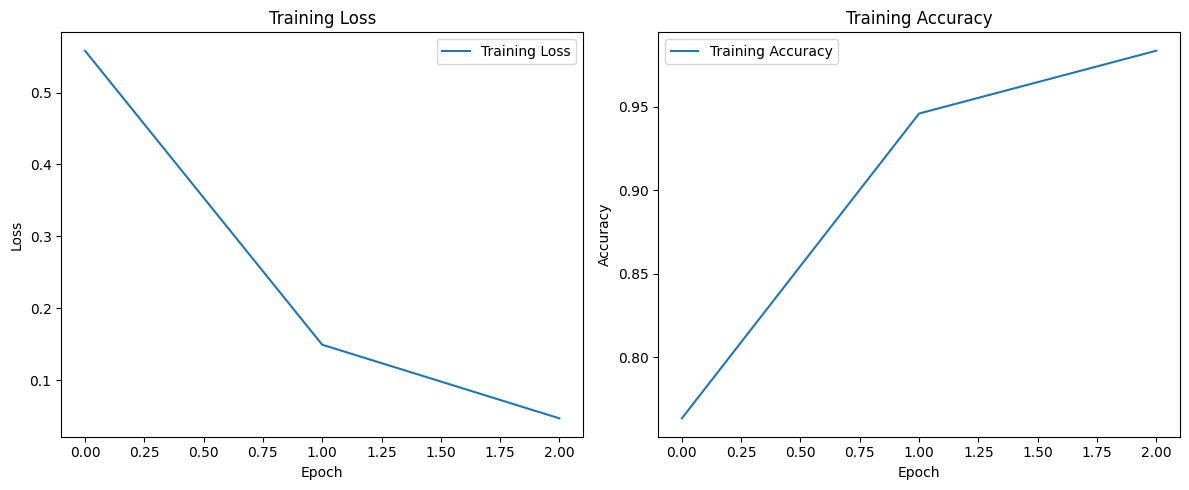

In [57]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [58]:
# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    all_predictions, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return classification_report(all_labels, all_predictions, target_names=['Positive', 'Negative', 'Neutral'], zero_division=0)

# Evaluate on validation and test sets
print("Validation Results:")
print(evaluate_model(model, val_loader))

print("\nTest Results:")
print(evaluate_model(model, test_loader))

Validation Results:
              precision    recall  f1-score   support

    Positive       0.93      0.95      0.94      1914
    Negative       0.96      0.95      0.95      2124
     Neutral       0.96      0.96      0.96      2932

    accuracy                           0.95      6970
   macro avg       0.95      0.95      0.95      6970
weighted avg       0.95      0.95      0.95      6970


Test Results:
              precision    recall  f1-score   support

    Positive       0.96      0.97      0.97       276
    Negative       0.99      0.97      0.98       266
     Neutral       0.97      0.98      0.98       456

    accuracy                           0.97       998
   macro avg       0.98      0.97      0.97       998
weighted avg       0.98      0.97      0.97       998



In [60]:
# Evaluate specific user reviews
reference_reviews = ["@GameDevStudio The new patch completely ruined the gameplay. Frame drops everywhere - unplayable!",
                    "Not sure if I should spend my money on this game, looks fun but a bit skeptical. Any thoughts?",
                    "Big thanks to @ConsoleBrand for their amazing customer support! My console is back to working perfectly.",
                    "Had to cancel my order because the delivery was delayed for the third time. Frustrating.",
                    "Absolutely loved the new RPG! Stunning graphics, deep story, and engaging gameplay."]

inputs = tokenize_data(reference_reviews, tokenizer)
inputs = {key: val.to(device) for key, val in inputs.items()}

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()

# Map predictions to sentiments
predicted_sentiments = [list(label_mapping.keys())[pred] for pred in predictions]
for review, sentiment in zip(reference_reviews, predicted_sentiments):
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment}")

Review: @GameDevStudio The new patch completely ruined the gameplay. Frame drops everywhere - unplayable!
Predicted Sentiment: Negative
Review: Not sure if I should spend my money on this game, looks fun but a bit skeptical. Any thoughts?
Predicted Sentiment: Neutral
Review: Big thanks to @ConsoleBrand for their amazing customer support! My console is back to working perfectly.
Predicted Sentiment: Positive
Review: Had to cancel my order because the delivery was delayed for the third time. Frustrating.
Predicted Sentiment: Negative
Review: Absolutely loved the new RPG! Stunning graphics, deep story, and engaging gameplay.
Predicted Sentiment: Positive


# Save Model

In [61]:
from transformers import DistilBertTokenizer

# Define the directory where the model will be saved
save_directory = 'distilbert_finetuned_3_epochs'

# Save the model
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

# Save the model configuration (optional, but usually included with `save_pretrained`)
model.config.save_pretrained(save_directory)

print(f"Model, tokenizer, and configuration saved to {save_directory}")

Model, tokenizer, and configuration saved to distilbert_finetuned_3_epochs


In [62]:
from huggingface_hub import login

# Log in to Hugging Face
# This will prompt you for your Hugging Face token, which you can find at: https://huggingface.co/settings/tokens
login()

In [63]:
from huggingface_hub import create_repo, upload_folder

username = "Savoxism"  
repo_name = "distilbert_sentiment_analysis_final" 
repo_id = f"{username}/{repo_name}"

# Create the repository
create_repo(repo_id, exist_ok=True)

# Upload the model
model_path = "/kaggle/working/distilbert_finetuned_3_epochs" 
upload_folder(
    repo_id=repo_id,
    folder_path=model_path,
    commit_message="Upload final fine-tuned DistilBERT for sentiment analysis",
)
print(f"Model uploaded to: https://huggingface.co/{repo_id}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Model uploaded to: https://huggingface.co/Savoxism/distilbert_sentiment_analysis_final


In [64]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# Define the path to the fine-tuned model
fine_tuned_model_dir = 'Savoxism/distilbert_sentiment_analysis_final'  # Update this to the directory where your model is saved

# Load the fine-tuned model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained(fine_tuned_model_dir)
tokenizer = DistilBertTokenizer.from_pretrained(fine_tuned_model_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set the model to evaluation mode

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [65]:
import torch

# Function to classify a single review
def classify_review(review, model, tokenizer, device, max_length=64):
    # Tokenize the review
    inputs = tokenizer(
        review,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    ).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()

    # Map prediction to sentiment
    label_mapping = {0: 'Positive', 1: 'Negative', 2: 'Neutral'}  # Ensure this matches your fine-tuned model
    sentiment = label_mapping[prediction]
    return sentiment

# Prompt user for a review
review = input("Enter a review: ")

# Classify the review
predicted_sentiment = classify_review(review, model, tokenizer, device)

# Display the result
print(f"\nReview: {review}")
print(f"Predicted Sentiment: {predicted_sentiment}")

Enter a review:  The product is amazing! I absolutely love it.



Review: The product is amazing! I absolutely love it.
Predicted Sentiment: Positive


In [68]:
# Prompt user for a review
review = input("Enter a review: ")

# Classify the review
predicted_sentiment = classify_review(review, model, tokenizer, device)

# Display the result
print(f"\nReview: {review}")
print(f"Predicted Sentiment: {predicted_sentiment}")

Enter a review:  Are you going to come down and play borderlands with us on saturday?



Review: Are you going to come down and play borderlands with us on saturday?
Predicted Sentiment: Neutral
